# Transferencia de aprendizaje y Transfer learning and 'fine-tuning'

Basado en https://www.tensorflow.org/tutorials/images/transfer_learning

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
assert (tf.__version__=='2.3.1'), 'Versión incorrecta de tensorflow, instale 2.3.1'

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Preprocesamiento de los datos

### Descarga

Para este tutorial, se usará un dataset de miles de imagenes de **perros** y **gatos**. Más información sobre cargar imágenes en este [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [26]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [27]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Muestra las 9 primeras imágenes del dataset de prueba:

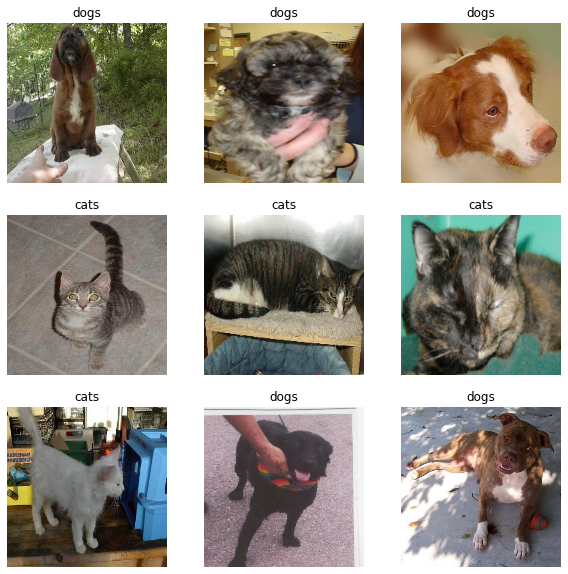

In [28]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Divide en dataset de validación original, en 20% para preuba y 80% para validación.

In [29]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [30]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configurar el rendimiento del dataset

*prefetch buffering* permite cargar imagenes del disco duro en bloques, para no llenar la RAM pero tampoco volver lento el entrenamiento, más información [aquí](https://www.tensorflow.org/guide/data_performance).

In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

Incrementar el dataset, aplicando artificialmente algunas transformaciones como rotación o desplazamineto (evita [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).Más información sobre *data augmentation* [aquí](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [32]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Nota: Estas transformaciones únicamente se aplican durante entrenamiento.

Ejemplo de las transformaciones:

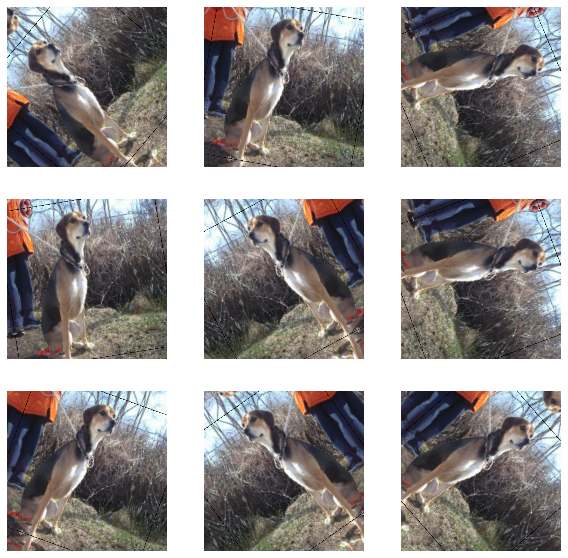

In [33]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Rescale pixel values

El modelo a usar espera imágenes entre `[-1,1]`, en lugar de `[0,255]`, así que se normaliza y centra en `0`.

In [34]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Nota: También se puede re-escalar de `[0,255]` a `[-1, 1]` usando una capa [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling).

In [35]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Nota: Dependiendo de la red base usada, se puede esperar una entrada en `[-1,1]` o en `[0,1]`.

## Modelo base desde redes convolucionales preentrenadas

Creará el modelo base a partir del modelo MobileNet V2 desarrollado en Google. Esto está pre-entrenado en el conjunto de datos ImageNet, un gran conjunto de datos que consta de 1,4 millones de imágenes y 1000 clases. ImageNet es un conjunto de datos de capacitación en investigación con una amplia variedad de categorías como jackfruit y syringe . Esta base de conocimiento nos ayudará a clasificar gatos y perros a partir de nuestro conjunto de datos específico.

Primero, debe elegir qué capa de MobileNet V2 usará para la extracción de características. La última capa de clasificación ("superior", ya que la mayoría de los diagramas de modelos de aprendizaje automático van de abajo hacia arriba) no es muy útil. En cambio, seguirá la práctica común de depender de la última capa antes de la operación de aplanar. Esta capa se denomina "capa de cuello de botella". Las características de la capa de cuello de botella conservan más generalidad en comparación con la capa final / superior.

Primero, cree una instancia de un modelo MobileNet V2 precargado con pesos entrenados en ImageNet. Al especificar el argumento include_top = False , carga una red que no incluye las capas de clasificación en la parte superior, lo que es ideal para la extracción de características.

In [36]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [37]:
# base_model.summary()

Este extractor de características convierte cada imagen de 160x160x3 en un bloque de características de 5x5x1280 . Veamos qué le hace a un lote de imágenes de ejemplo:

In [38]:
image_batch, label_batch = next(iter(train_dataset))
print(f'image_batch.shape={image_batch.shape}')
feature_batch = base_model(image_batch)
print(f'feature_batch.shape={feature_batch.shape}')

image_batch.shape=(32, 160, 160, 3)
feature_batch.shape=(32, 5, 5, 1280)


### Extracción de características

En este paso, congelará la base convolucional creada en el paso anterior y la utilizará como extractor de características. Además, agrega un clasificador encima y entrena al clasificador de nivel superior.

### Congelar la base convolucional

Es importante congelar la base convolucional antes de compilar y entrenar el modelo. La congelación (al establecer layer.trainable = False) evita que los pesos de una capa determinada se actualicen durante el entrenamiento. MobileNet V2 tiene muchas capas, por lo que si se configura el indicador de trainable todo el modelo en False, se congelarán todas.

In [39]:
base_model.trainable = False

In [40]:
# Let's take a look at the base model architecture
# base_model.summary()

### Agregar un encabezado de clasificación

Para generar predicciones a partir del bloque de tf.keras.layers.GlobalAveragePooling2D , tf.keras.layers.GlobalAveragePooling2D las ubicaciones espaciales espaciales de 5x5 , utilizando una capa tf.keras.layers.GlobalAveragePooling2D para convertir las tf.keras.layers.GlobalAveragePooling2D en un solo vector de 1280 elementos por imagen.

In [41]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplique una capa tf.keras.layers.Dense para convertir estas características en una única predicción por imagen. No necesita una función de activación aquí porque esta predicción se tratará como un logit o un valor de predicción sin procesar. Los números positivos predicen la clase 1, los números negativos predicen la clase 0.

In [42]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Cree un modelo encadenando las capas de aumento de datos, cambio de escala, base_model y extractor de características utilizando la[ API funcional de Keras](https://www.tensorflow.org/guide/keras/functional) . Como se mencionó anteriormente, use training = False ya que nuestro modelo contiene una capa BatchNormalization.

In [43]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compila el modelo

Compile el modelo antes de entrenarlo. Dado que hay dos clases, use una pérdida de entropía cruzada binaria con from_logits=True ya que el modelo proporciona una salida lineal.

In [44]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)             

Los parámetros de 2.5M en MobileNet están congelados, pero hay 1.2K parámetros entrenables en la capa Dense. Estos se dividen entre dos objetos tf.Variable , los pesos y los sesgos.

In [46]:
len(model.trainable_variables)

2

### Entrena el modelo

Después de entrenar durante 10 épocas, debería ver una precisión de ~ 94% en el conjunto de validación.

In [47]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 2s 82ms/step - loss: 0.9492 - accuracy: 0.3193


In [48]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.95
initial accuracy: 0.32


In [49]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 142ms/step - loss: 0.7598 - accuracy: 0.5460 - val_loss: 0.6408 - val_accuracy: 0.5866
Epoch 2/10
63/63 [==============================] - 9s 141ms/step - loss: 0.5725 - accuracy: 0.6785 - val_loss: 0.4620 - val_accuracy: 0.7673
Epoch 3/10
63/63 [==============================] - 9s 146ms/step - loss: 0.4499 - accuracy: 0.7715 - val_loss: 0.3605 - val_accuracy: 0.8688
Epoch 4/10
63/63 [==============================] - 9s 144ms/step - loss: 0.3815 - accuracy: 0.8145 - val_loss: 0.2885 - val_accuracy: 0.9047
Epoch 5/10
63/63 [==============================] - 9s 144ms/step - loss: 0.3232 - accuracy: 0.8550 - val_loss: 0.2466 - val_accuracy: 0.9245
Epoch 6/10
63/63 [==============================] - 9s 145ms/step - loss: 0.2921 - accuracy: 0.8735 - val_loss: 0.2105 - val_accuracy: 0.9406
Epoch 7/10
63/63 [==============================] - 9s 143ms/step - loss: 0.2649 - accuracy: 0.8820 - val_loss: 0.1884 - val_accuracy: 0.9480
Epoch 

### Curvas de aprendizaje

Echemos un vistazo a las curvas de aprendizaje de la precisión / pérdida de entrenamiento y validación cuando se utiliza el modelo base de MobileNet V2 como extractor de funciones fijas.

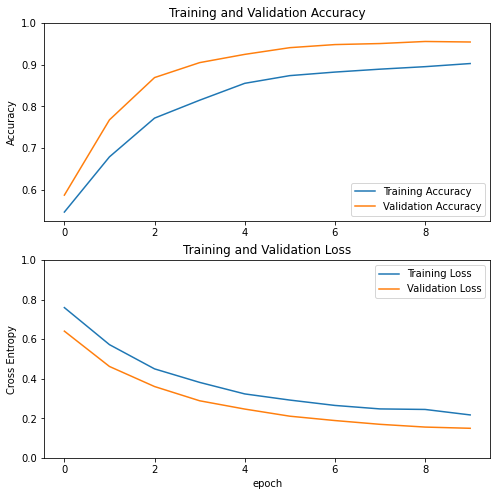

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Nota: Si se pregunta por qué las métricas de validación son claramente mejores que las métricas de entrenamiento, el factor principal es que capas como tf.keras.layers.BatchNormalization y tf.keras.layers.Dropout afectan la precisión durante el entrenamiento. Se desactivan al calcular la pérdida de validación.

En menor medida, también se debe a que las métricas de entrenamiento informan el promedio de una época, mientras que las métricas de validación se evalúan después de la época, por lo que las métricas de validación ven un modelo que se ha entrenado un poco más.

## Sintonia FINA

En el experimento de extracción de características, solo estaba entrenando algunas capas sobre un modelo base de MobileNet V2. Los pesos de la red preentrenada no se actualizaron durante el entrenamiento.

Una forma de aumentar aún más el rendimiento es entrenar (o "ajustar") los pesos de las capas superiores del modelo previamente entrenado junto con el entrenamiento del clasificador que agregó. El proceso de entrenamiento obligará a ajustar las ponderaciones de los mapas de características genéricas a las características asociadas específicamente con el conjunto de datos.

Nota: Esto solo debe intentarse después de haber entrenado el clasificador de nivel superior con el modelo entrenado previamente configurado como no entrenable. Si agrega un clasificador inicializado aleatoriamente sobre un modelo previamente entrenado e intenta entrenar todas las capas de manera conjunta, la magnitud de las actualizaciones de gradiente será demasiado grande (debido a los pesos aleatorios del clasificador) y su modelo previamente entrenado olvida lo que ha aprendido.

Además, debe intentar ajustar una pequeña cantidad de capas superiores en lugar de todo el modelo de MobileNet. En la mayoría de las redes convolucionales, cuanto más arriba está una capa, más especializada es. Las primeras capas aprenden características muy simples y genéricas que se generalizan a casi todos los tipos de imágenes. A medida que asciende, las características son cada vez más específicas del conjunto de datos en el que se entrenó el modelo. El objetivo del ajuste fino es adaptar estas características especializadas para trabajar con el nuevo conjunto de datos, en lugar de sobrescribir el aprendizaje genérico.

### Descongele las capas superiores del modelo

Todo lo que necesita hacer es descongelar base_model y configurar las capas inferiores para que no se puedan entrenar. Luego, debe volver a compilar el modelo (necesario para que estos cambios surtan efecto) y reanudar el entrenamiento.


In [51]:
base_model.trainable = True

In [52]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False

Number of layers in the base model:  155


### Compila el modelo

Como está entrenando un modelo mucho más grande y desea readaptar los pesos preentrenados, es importante utilizar una tasa de aprendizaje más baja en esta etapa. De lo contrario, su modelo podría sobreajustarse muy rápidamente.

In [53]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)             

In [55]:
len(model.trainable_variables)

58

### Continuar entrenando el modelo

Si se entrenó para la convergencia antes, este paso mejorará su precisión en algunos puntos porcentuales.

In [56]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 13s 210ms/step - loss: 0.1590 - accuracy: 0.9365 - val_loss: 0.0828 - val_accuracy: 0.9752
Epoch 11/20
63/63 [==============================] - 12s 192ms/step - loss: 0.1341 - accuracy: 0.9420 - val_loss: 0.0514 - val_accuracy: 0.9777
Epoch 12/20
63/63 [==============================] - 12s 196ms/step - loss: 0.1148 - accuracy: 0.9540 - val_loss: 0.0544 - val_accuracy: 0.9703
Epoch 13/20
63/63 [==============================] - 12s 194ms/step - loss: 0.1094 - accuracy: 0.9555 - val_loss: 0.0508 - val_accuracy: 0.9740
Epoch 14/20
63/63 [==============================] - 13s 199ms/step - loss: 0.0941 - accuracy: 0.9610 - val_loss: 0.0541 - val_accuracy: 0.9752
Epoch 15/20
63/63 [==============================] - 12s 193ms/step - loss: 0.0889 - accuracy: 0.9630 - val_loss: 0.0505 - val_accuracy: 0.9777
Epoch 16/20
63/63 [==============================] - 12s 193ms/step - loss: 0.0869 - accuracy: 0.9665 - val_loss: 0.0621 - val_accuracy:

Después de un ajuste fino, el modelo casi alcanza el 98% de precisión en el conjunto de validación.

In [57]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

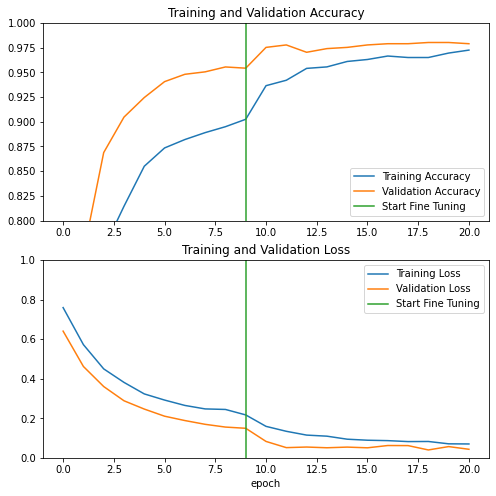

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Evaluación y predicción
Por último, puede verificar el rendimiento del modelo en nuevos datos utilizando el conjunto de prueba.

In [59]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 71ms/step - loss: 0.0305 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Y ahora está listo para usar este modelo para predecir si su mascota es un gato o un perro.



Predictions:
 [0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1]
Labels:
 [0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1]


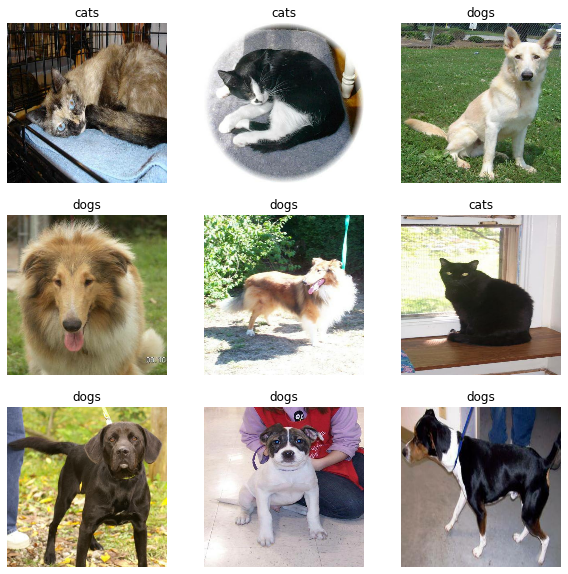

In [60]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Resumen

* **Uso de un modelo previamente entrenado para la extracción de características**: cuando se trabaja con un conjunto de datos pequeño, es una práctica común aprovechar las características aprendidas por un modelo entrenado en un conjunto de datos más grande en el mismo dominio. Esto se hace creando una instancia del modelo previamente entrenado y agregando un clasificador completamente conectado en la parte superior. El modelo preentrenado se "congela" y solo los pesos del clasificador se actualizan durante el entrenamiento. En este caso, la base convolucional extrajo todas las características asociadas con cada imagen y usted solo entrenó un clasificador que determina la clase de imagen dado ese conjunto de características extraídas.

* **Ajuste de un modelo previamente entrenado**: para mejorar aún más el rendimiento, es posible que desee reutilizar las capas de nivel superior de los modelos previamente entrenados para el nuevo conjunto de datos mediante un ajuste fino. En este caso, ajustó sus pesos de manera que su modelo aprendiera características de alto nivel específicas del conjunto de datos. Esta técnica generalmente se recomienda cuando el conjunto de datos de entrenamiento es grande y muy similar al conjunto de datos original en el que se entrenó el modelo previamente entrenado.

Para obtener más información, visite la [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


In [ ]:
# MIT License
#
# Copyright (c) 2017 François Chollet                       # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.